# Exploratory Data Analaysis: Telco Customer Churn

In this notebook we will go through analyzing Telco Customer Churn, made available on Kaggle. We will look at several factors like how long they've been a customer, contract, payment method and many others, all related to customers that have signed up and use this knowledge to build a model that can predict which customers are likely to leave. Each row of the dataset represents a customer, and each column a customer's attributes.

The dataset contains information about the customers who left in the last month, which can be found in the 'Churn' column. We will also have the service that they signed up for, like phone, streaming, tech support. We would also have the customer account information and demographic info about customers.

In [4]:
from statistics import correlation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

data = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")

#### 2. Initial data inspection

Get a high-level overview of the data's structure, types and potential issues.

In [5]:
print(data.head())

print('DataFrame Info')
data.info()

print('Descriptive Statistics')
print(data.describe())

print('Total missing values')
print(data.isnull().sum())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

We can see that many columns have object as their type. I'm afraid of empty strings which our previous check would not detect. Let's do a check specific for this specific columns:

In [2]:
object_cols = data.select_dtypes(include=['object']).columns

for col in object_cols:
    empty_count = (data[col].str.strip() == '').sum()

    if empty_count > 0:
        print(f"Column '{col}': Found {empty_count} empty string(s)")
    else:
        pass

Column 'TotalCharges': Found 11 empty string(s)


#### 3. Data cleaning and formatting

My fears were real, there were 11 empty string for Total Charges column. Let's do a bit of data cleaning and formatting. Let's replace the empty strings with 0 value, and drop the customerID column which is a unique identifier, and has zero predictive power.

In [10]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges']= data['TotalCharges'].fillna(0)
data = data.drop('customerID', axis=1)


#### 4. Target Variable Analysis

Let's analyze the distribution of the 'Churn' column.

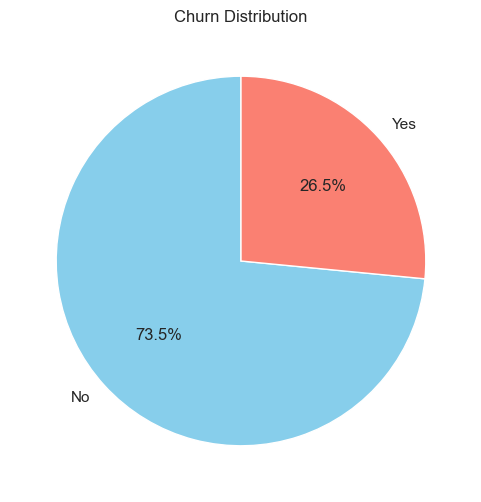

In [7]:
plt.figure(figsize=(6, 6))
data['Churn'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Churn Distribution')
plt.ylabel('')
plt.show()

We can see an imbalanced dataset, with around three times more 'No' than 'Yes'. So when the dataset will be split into training and testing, we should stratify the target variable y. Otherwise, we could end up with a training and testing set with significantly different distributions, which would make the evaluation of the model unreliable.

Further, choosing our metrics here is crucial. Let's say we aim for accuracy metric. If we have a simple naive model that always predicts 'No', we have a 73.5% accuracy. This makes accuracy a misleading and useless metric for this problem. We need to use metrics that are better suited for this test case. We could use a confusion matrix to visualize performance. Also on Precision, Recall and F1-Score. The AUC-ROC is also a robust metric for imbalanced classification.

Due to the imbalanced data the model could develop a bias towards the majority, 'No', class. They will learn the pattern for 'No' very well, but perform poorly on prediction 'Yes'. We could keep in mind a few corrective techniques:
* class weights, penalizing the model more heavily for misclassifying the minority class
* resampling with SMOTE, generating synthetic data points for the minority class
* also picking appropriate algorithms, tree-based models handle class imbalance better than Logistic Regression. However, the personal goal with this project was to get familiar with Logistic Regression models. So I'm going to start out with that, finishing with some tree-based models.

#### 5. Analyzing Single Features (Univariate Analysis)

Let's take each feature individually and try to understand its distribution.

##### Numerical Features:

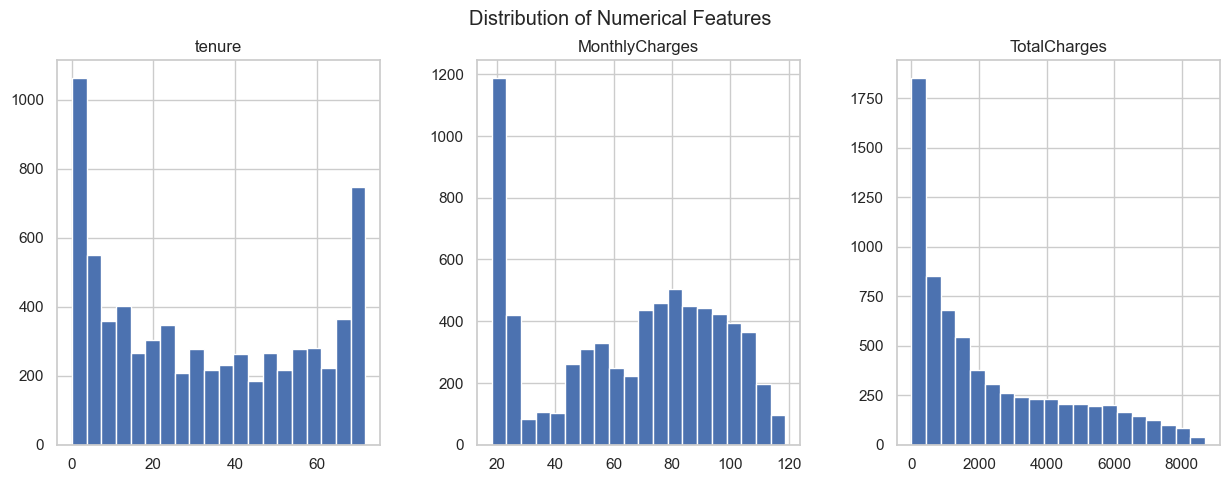

In [14]:
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
data[numerical_features].hist(bins=20, figsize=(15, 5), layout=(1, 3))
plt.suptitle('Distribution of Numerical Features')
plt.show()

First we look at tenure, which means how long a customer has been with the company. No unit of measure here. It looks like there is a huge spike of new customers, followed closely by long-term loyal customers. Looks like a bimodal distribution, showing a high volume of new sign-ups and a core of loyal customers.

In the second histogram we can see the customer's monthly bill amount. The most common value sits around 20 for around 1200 customers. The next common value would be around 80 for 500 customers or so, clearly not as frequent.

Lastly we are looking at the total charges histogram, which is the cumulative total amount a customer has paid over their entire membership. A very large number of customers have low total charges, but as total increases the customers drop significant. This looks to be a right-skewed distribution.

##### Categorical Features:

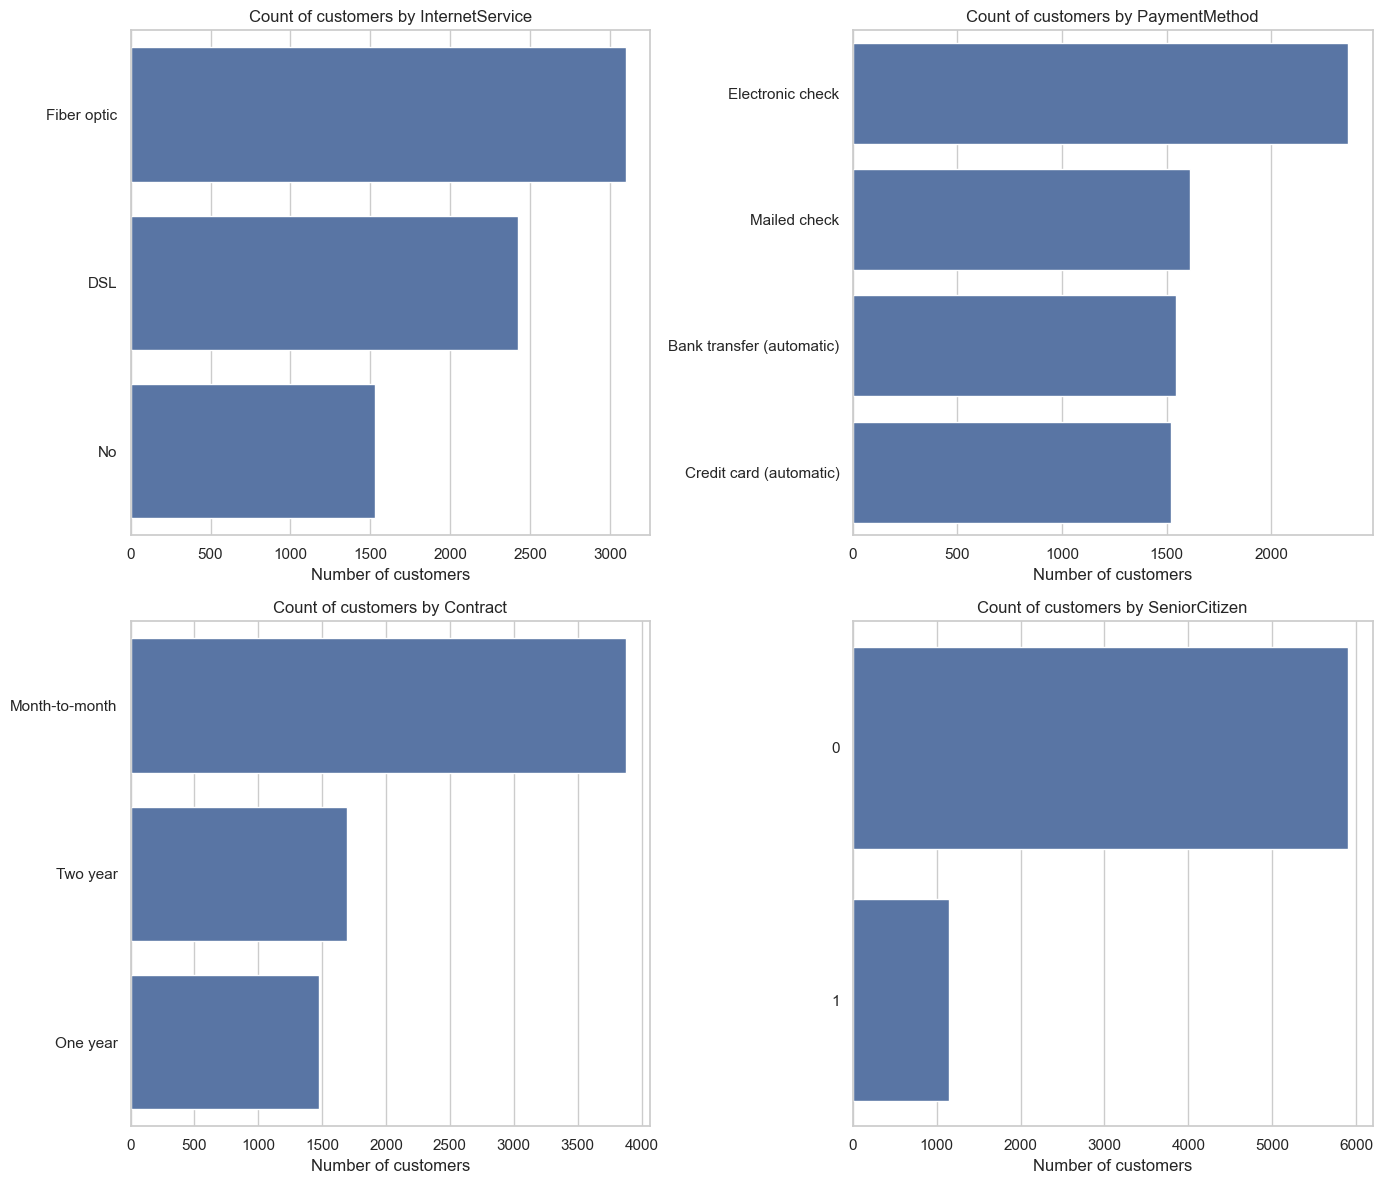

In [16]:
categorical_features = ['InternetService', 'PaymentMethod', 'Contract', 'SeniorCitizen']
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    sns.countplot(y=col, data=data, ax=axes[i], order=data[col].value_counts().index)
    axes[i].set_title(f'Count of customers by {col}')
    axes[i].set_xlabel('Number of customers')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

If we look at these count plots, we can notice the following the count of customers by:
* InternetService: Fiber optic seems to be the leading internet service, but very close it's DSL. A good chunk here, around 1500 customers have no internet service. This is an uneven distribution. As a final conclusion for this category we can say that the customer base is segmented. The churn behavior will differ dramatically between the Fiber optic/DSL/No Internet customers. For example the No internet service customers will churn from reasons related to other services, like phone.
* PaymentMethod: The leading category is Electronic Check. We have three distributions Mailed check/Bank transfer/Credit card are somewhat clustered, the Electronic check is a clear preference here. The Electronic check is a manual payment whereas bank transfers and credit card are automatic. Customers who have to make a conscious decision to pay each month may be more likely to churn than those on autopay
* Contract: The dominant category is Month-to-month, with more customers than the two year/one year combined. This is heavily weighted towards the month-to-month category. Customers in this category have the lowest barrier to leaving.
* Senior citizen: The data is heavily imbalanced, there are way more non-seniors than senior citizens. This correlated with the first count plot, is to be expected, the primary demographic are non-seniors consumers of high-speed internet.

As an important side note, we will probably end up using one-hot encoding for categorical features like gender, partner, dependents, etc.

#### 6. Analyzing Feature Relationships (Bivariate Analysis)

Further we will analyze how each feature relates to the target. We should follow the same approach, first take a look at the numerical then to categorical features.

##### Numerical Features vs Churn:

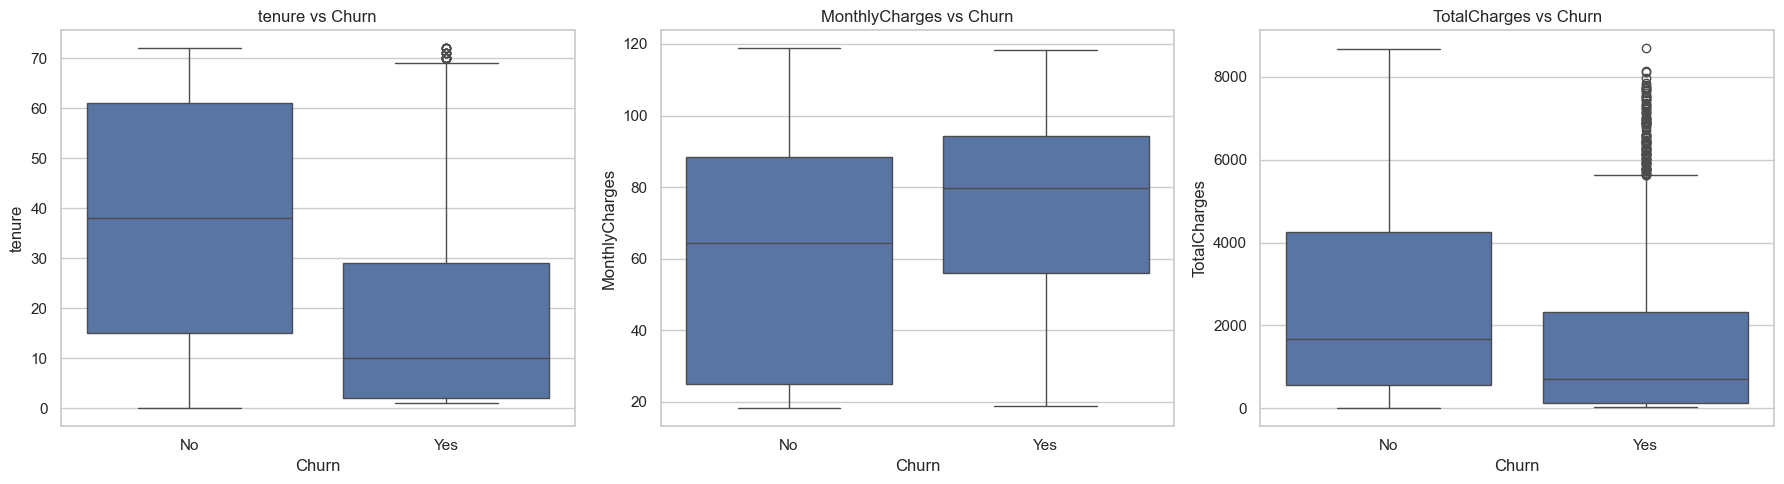

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.boxplot(x='Churn', y=col, data=data, ax=axes[i])
    axes[i].set_title(f'{col} vs Churn')

plt.tight_layout()
plt.show()

For the first box plot, we can see that customers who churn have a significantly lower median tenure. This implies newer customers are more likely to leave.

For the second one, the median monthly charge is higher for the customers who churn. A possibility might be that they leave in search for cheaper services.

Lastly, the median for Yes is lower than for No category. This is kinda expected having in mind that from the first box plot, we saw that people who churn have a lower tenure, and the total charges are highly correlated with tenure. However, there are a lot of customers in the folks who churned that had a high total charge. High paying customers who leave will have a big financial impact.

Box plots are great, but they hide the shape of the distribution. We could go further and use violin plots. They show both the distribution shape and summary statistics, giving a richer view of how features differ between churners and non-churners.

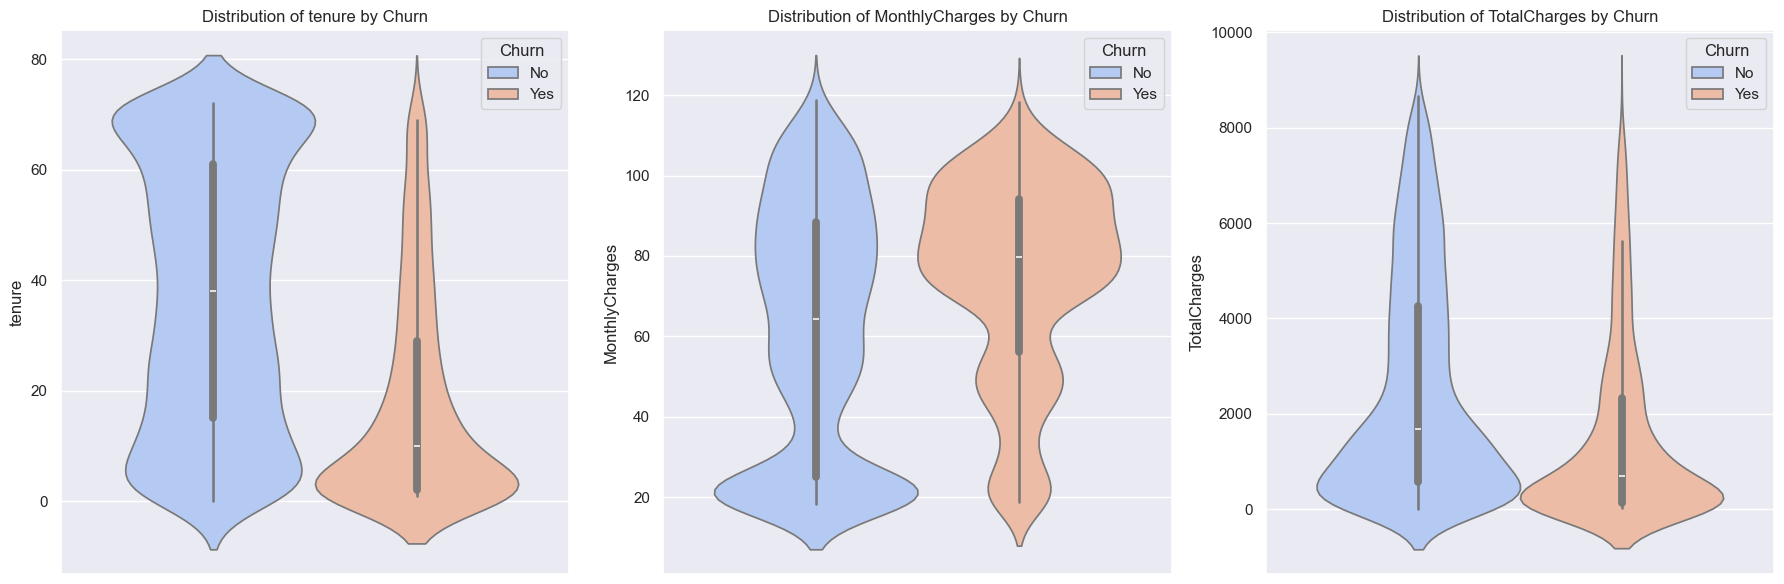

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.violinplot(hue='Churn', y=col, data=data, ax=axes[i], palette='coolwarm')
    axes[i].set_title(f'Distribution of {col} by Churn')

plt.tight_layout()
plt.show()

So let's break this down one by one:
* Distribution of tenure by Churn: In the 'No' category we can notice two bumps. This is a bimodal distribution meaning it has two distinct peaks. This is an indication that we have two groups of loyal customers, brand-new ones and long-term ones. The shape is thinner in the middle, which means that customers are less numerous. Now for the Churn=Yes category, the distribution is right-skewed, with a vast majority of customers who churn early in their lifecycle. The median can be seen to be extremely low compared to non-churners
* Distribution of MonthlyCharges by Churn: For the Churn=No category, the distribution can be seen that is focused at the low end. A large number of loyal customers are paying low amounts fees, with some high paying ones close by. For the Yes category here, the concentration happens in the high monthly charge rate. The median also is higher for the churners than the loyal customers
* Distribution of TotalCharges by Churn: the distribution is spread out but skewed toward higher total charges, which is to be expected as loyal customers end up paying more during their lifecycle. The median for the churners here is much lower. This might contradict the previous plot, Distribution of MonthlyCharges by Churn, but combined with Distribution of tenure by Churn makes perfect sense. Churners pay more per month, but end up leaving quickly, so their lifetime value remains very low.

The violin plots paints a coherent story: the churners are new customers, paying a high monthly fee, and have a total charge that is low because they don't stick around long enough to accumulate them. The loyal customer is a bit more bimodal, on one hand we have those that contract cheap plans, and on the other hand those with a high tenure who built a considered amount in their lifetime.

The most significant driver for churn appears to be highly monthly charges, especially for new customers.

##### Categorical Features vs Churn:

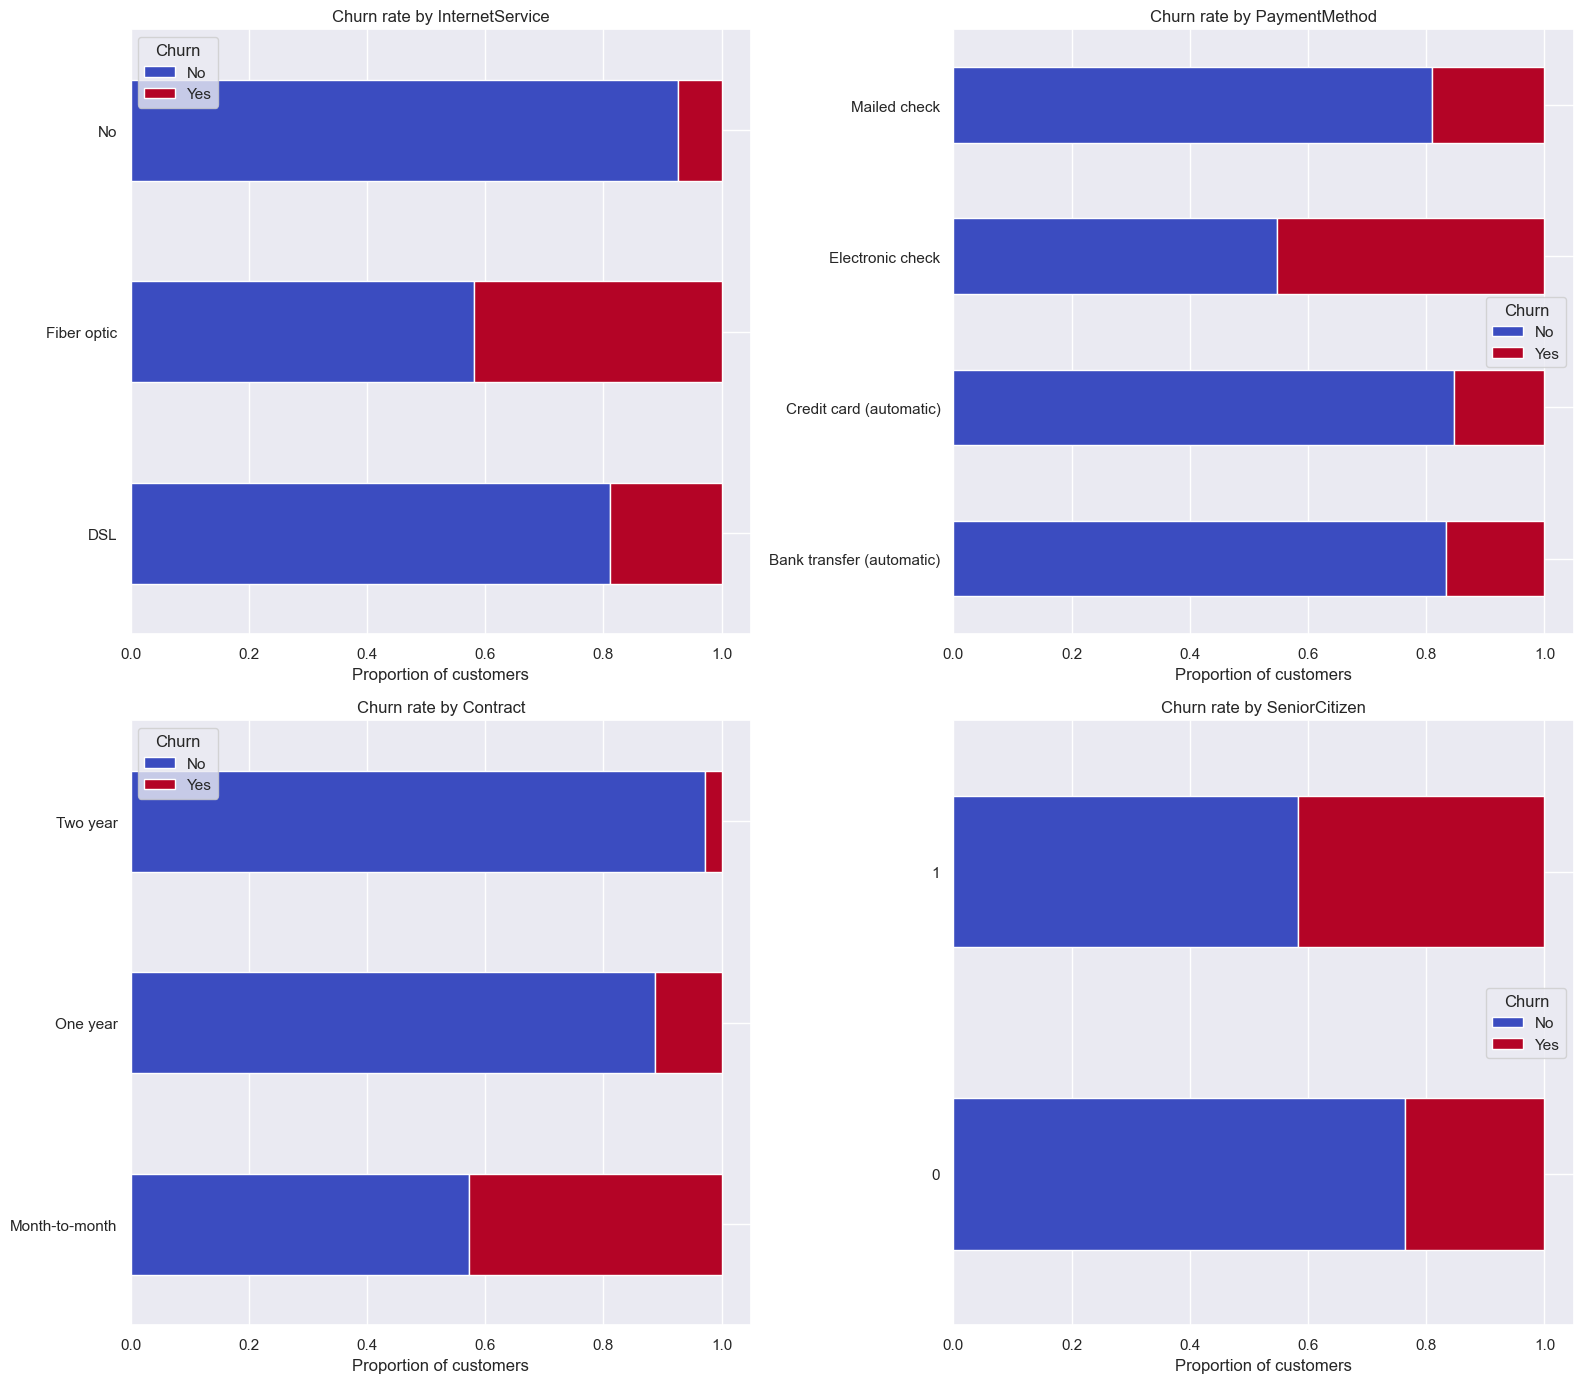

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    ct = pd.crosstab(data[col], data['Churn'], normalize='index')
    ct.plot(kind='barh', stacked=True, ax=axes[i], colormap='coolwarm')
    axes[i].set_title(f'Churn rate by {col}')
    axes[i].set_xlabel('Proportion of customers')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

Let's take them in order:
* Churn rate by InternetService: Customers with Fiber optic have a churn rate of 40%, making this the highest risk group. On the other side we have the No internet service customers which are the most loyal. Somewhere in between is the DSL category with a churn rate of around 20%.
* Churn rate by PaymentMethod: Customers using Electronic are by far the most likely to churn, around 45%. This manual, non-recurring payment creates an easy exit for monthly paying customers. The safest are the automatic payments which have rates smaller than 20%.
* Churn rate by Contract: from the plot it seems that the Month-to-month customers are very volatile, with a churn rate over 40%. Whereas the one year, and especially two year contracts are highly loyal. The churn rate for the two year is almost negligible.
* Churn rate by SeniorCitizen: Surprisingly the senior category has a higher churn rate, over 40%. The young folks churn rate is almost half, sitting around 20%. Although if we recall 'Count of customers by SeniorCitizen' we have around 6 times more young folks than seniors. Keeping this in mind, volume wise the impact of non-senior citizens is way higher, around 1500 churners whereas SeniorCitizens are around 400 churners.

Correlating this with the Univariate analysis, I might be tempted to make a hypothesis: customers are leaving for cheaper internet services alternatives.

The largest group of customers are non-seniors and the most popular service is Fiber Optic. The highest churn service is Fiber Optic, over 40%. The intersection of the previous facts, means that the largest churn comes from non-senior customers with Fiber Optic plans.

Before moving further let's check how key features interact with each other, and here I have InternetService, Churn rate and Contract in mind. Let's use this time a faceted plot to check these features side by side. With no further ado:

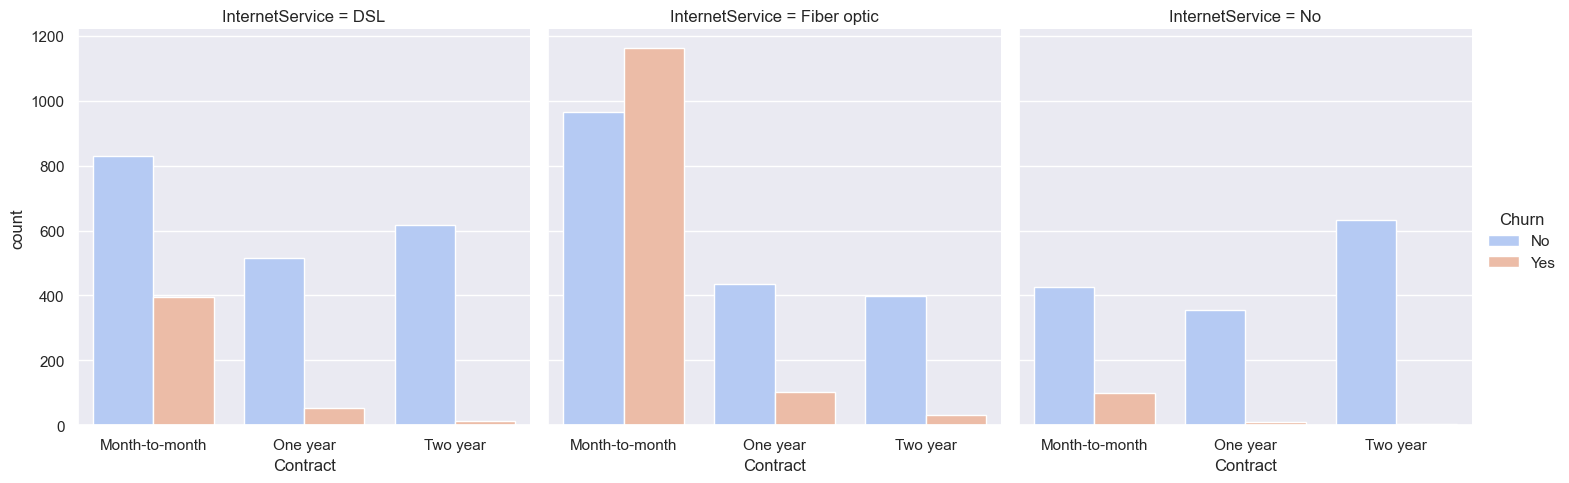

In [34]:
sns.catplot(x='Contract', col='InternetService', hue='Churn', data=data, kind='count', palette='coolwarm')
plt.show()

For the leftmost plot, the DSL Internet service, it seems that it retains more customers than loses. The risk for the Month-to-month customers is moderate. For the center, Fiber optic plot, I think it depicts the churn problem. The churn bar for the month-to-month customers is massive, and it overpasses the customers it retains. We have around 1200 customers dropping in this category. Lastly the No internet reinforces the points we made earlier, in the Univariate analysis, the customers in this category are very loyal. What this graphs add is that the churn is minimal across all contract types.

#### 7. Correlation Analysis

It's now time move to multicollinearity between numerical features. What's a better way than looking at a plot. So let's plot the correlation matrix.

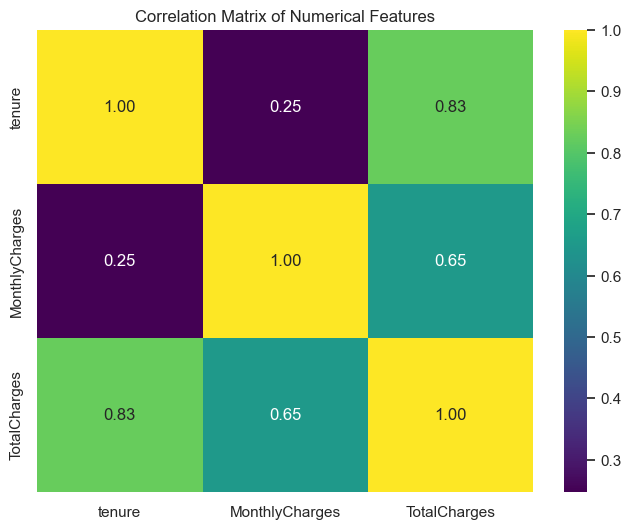

In [30]:
plt.figure(figsize=(8, 6))
correlation_matrix = data[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

There is a strong correlation between tenure and TotalCharges, with a value of 0.83. This should not come as a surprise as the longer a customer stays, high tenure, the more they will end up paying in total. A slightly more moderate correlation is between Total Charges and Monthly Charges, sitting at 0.65.
We can handle this in a few ways. We can remove one of the variable, usually keep the one that has a higher correlation with the target variable. We could combine the variables, using a dimensionality reduction technique like Principal Component Analysis (PCA). Or/and use regularization L1 or L2 regularization.

To determine which one of the two, Total Charges and tenure has the highest correlation let's plot this one more time, this time using the Churn target as well.

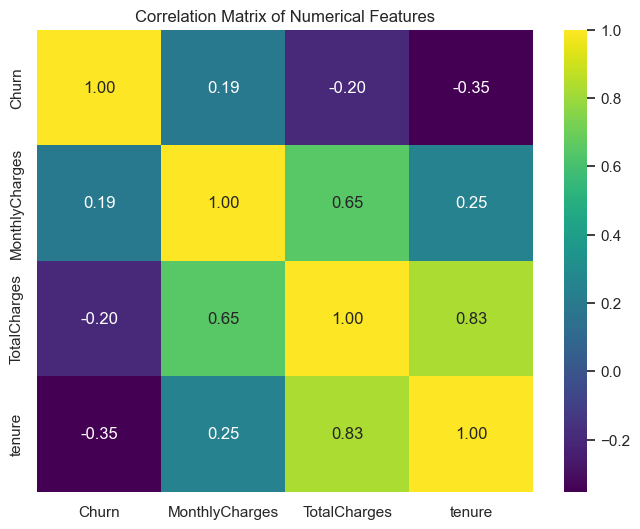

In [32]:
plt.figure(figsize=(8, 6))
data_corr = data[numerical_features].assign(
    Churn=(data['Churn'] == 'Yes').astype(int)
)
corr_matrix = data_corr.corr()
k = 4
top_k_cols = corr_matrix.nlargest(4, 'Churn')['Churn'].index
top_k_corr_matrix = corr_matrix.loc[top_k_cols, top_k_cols]
sns.heatmap(top_k_corr_matrix, annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

The absolute value for tenure has a higher value with Churn than TotalCharges. This means we can keep tenure feature.

An alternative here would be to use regularization. This is a more data-driven approach. Instead of deciding to drop the column, we will let the model decide its importance.

#### 8. Conclusions

I think this was a useful exercise that will influence our way of designing the data processing and picking the bests model. So let's describe down below the churner profile and finish this notebook with an action plan.

##### Churner Profile:

The above analysis paints a clear picture of the customer that is most likely to leave:

* Month-to-month contract: this kind of customer doesn't have any long-term commitment.
* Fiber optic user: while paying a premium service, this has the highest churn rate, over 40%. The Month-to-month customers of this service, have the highest churn rate
* Electronic check: manual payment is a monthly reoccurring decision that a customer has to make, which leaves the gate open once every month, for the customer to leave. More than 40% of customers that are using this method drop.
* Tenure: the box plots showed us that the customer who churns has a median value of 10 months or so, compared with a loyal customer which has almost four times more.

Hypothesis: The main driver for churn is price sensitivity among non-commited customers that also have a high-cost plan. Customers that are on flexible month-to-month contracts for premium internet service, like Fiber Optic, are quick to leave.


##### Next steps:

1. Data preprocessing:
      * Implement the fix for the 11 empty string in TotalCharges column. Convert it to a numeric value and fill NaN with zeros.
      * One-hot encoding: convert the target column Churn, and other binary values like gender, partner, dependents to 0 or 1
      * Scaling: scale numerical features, tenure, MonthlyCharges, TotalCharges using a StandardScaler. This will be important if we want a Logistic Regression model to perform correctly
2. Feature engineering:
    * Multicollinearity: use regularization. The model will determine feature importance.
3. Modelling:
      * Data splitting: split the data into training and testing sets. Recall Target Variable Analysis pie plot, and the first sentence we wrote: we must stratify the target variable in order to ensure class imbalance is preserved in both sets.
      * Baseline model: Logistic Regression. This was the main motivator for this starting this project. We must all the tools available to make this perform good, like penalizing misclassifications of the minority class more heavily
      * Comparison model: compare the baseline model with a high performer on tabular data like a tree-based model
      * Evaluation: how we do this is crucial. We won't rely on accuracy metric. We will generate a Classification Report to compare Precision, Recall, and F1-Score. We will also use a AUC-ROC curve to compare both models